In [1]:

#BPNN
iteration=1000
learning_rate=0.7

In [24]:
import numpy as np
from random import random
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.ticker as mticker
df=pd.read_excel('D:\\learning article\\final\\Data.xlsx')
df1=pd.read_excel('D:\\learning article\\final\\mse.xlsx')
df2=pd.read_excel('D:\\learning article\\final\\trainWithFunction.xlsx')
#df3=pd.read_excel('D:\\learning article\\final\\DEA-CCR _abcep.xlsx')

y_ccr=np.array(df.loc[:,'target-ccr'])
y_bcc=np.array(df.loc[:,'target-bcc'])
y_fdh=np.array(df.loc[:,'target-FDH'])
x=np.array(df.iloc[:,[0,1,2,3,4]])



In [3]:

#test_result={'MSE': [], 'Relative-Error': [], 'Weight':[]}


#k_test= {'MSE': [], 'Relative-Error': [], 'Weight':[],'output':[]}
class MLP(object):
    """A Multilayer Perceptron class.
    """

    def __init__(self, num_inputs=3, hidden_layers=[3, 3], num_outputs=2):
        """Constructor for the MLP. Takes the number of inputs,
            a variable number of hidden layers, and number of outputs
        Args:
            num_inputs (int): Number of inputs
            hidden_layers (list): A list of ints for the hidden layers
            num_outputs (int): Number of outputs
        """

        self.num_inputs = num_inputs
        self.hidden_layers = hidden_layers
        self.num_outputs = num_outputs

        # create a generic representation of the layers
        layers = [num_inputs] + hidden_layers + [num_outputs]

        # create random connection weights for the layers
        weights = []
        for i in range(len(layers) - 1):
            w = np.random.rand(layers[i], layers[i + 1])
            weights.append(w)
        self.weights = weights

        # save derivatives per layer
        derivatives = []
        for i in range(len(layers) - 1):
            d = np.zeros((layers[i], layers[i + 1]))
            derivatives.append(d)
        self.derivatives = derivatives

        # save activations per layer
        activations = []
        for i in range(len(layers)):
            a = np.zeros(layers[i])
            activations.append(a)
        self.activations = activations


    def forward_propagate(self, inputs):
        """Computes forward propagation of the network based on input signals.
        Args:
            inputs (ndarray): Input signals
        Returns:
            activations (ndarray): Output values
        """

        # the input layer activation is just the input itself
        activations = inputs

        # save the activations for backpropogation
        self.activations[0] = activations
        
        # iterate through the network layers
        for i, w in enumerate(self.weights):
           
           
            # calculate matrix multiplication between previous activation and weight matrix
            net_inputs = np.dot(activations, w)

            # apply sigmoid activation function
            activations = self._sigmoid(net_inputs)
          
            # save the activations for backpropogation
            self.activations[i + 1] = activations
            
        # return output layer activation
        
        return activations,self.weights
    
    
   

    def back_propagate(self, error):
        """Backpropogates an error signal.
        Args:
            error (ndarray): The error to backprop.
        Returns:
            error (ndarray): The final error of the input
        """

        # iterate backwards through the network layers
        for i in reversed(range(len(self.derivatives))):

            # get activation for previous layer
            activations = self.activations[i+1]

            # apply sigmoid derivative function
            delta = error * self._sigmoid_derivative(activations)

            # reshape delta as to have it as a 2d array
            delta_re = delta.reshape(delta.shape[0], -1).T

            # get activations for current layer
            current_activations = self.activations[i]

            # reshape activations as to have them as a 2d column matrix
            current_activations = current_activations.reshape(current_activations.shape[0],-1)

            # save derivative after applying matrix multiplication
            self.derivatives[i] = np.dot(current_activations, delta_re)

            # backpropogate the next error
            error = np.dot(delta, self.weights[i].T)
            
    


    def train(self, inputs, targets, epochs, learning_rate,number_of_data):
        """Trains model running forward prop and backprop
        Args:
            inputs (ndarray): X
            targets (ndarray): Y
            epochs (int): Num. epochs we want to train the network for
            learning_rate (float): Step to apply to gradient descent
        """
        
        train_result= {'MSE': [], 'Weight':[],'Relative-Error':[]}
        result=pd.DataFrame(index=np.arange(1,number_of_data+1),columns=['type','DMU','target','output'])
        # now enter the training loop
        for i in range(epochs):
            sum_errors = 0
           
            
            # iterate through all the training data
            for j, input in enumerate(inputs):
                target = targets[j]
                
                
                # activate the network!
                out = self.forward_propagate(input[[1,2,3,4]])
                
                output=float(out[0])
                #print(target)
                #print(output)
                error = target - output
                
                
                if (i==epochs-1):
                    
                    result.loc[int(inputs[j,0])]=['Train',inputs[j,0],target,output]
                    train_result['Relative-Error'] += [abs(target-output)/target]
                    train_result['Weight']=out[1]
                    #print(k['Weight'])
                    #print('----')
                    #print(out[1])
                    #k['output']+=[out[0]]
                #print(output)
                
                self.back_propagate(error)

                # now perform gradient descent on the derivatives
                # (this will update the weights
                self.gradient_descent(learning_rate)

                # keep track of the MSE for reporting later
                sum_errors += self._mse(target, output)
                ##relative_error.append((abs(target-output))/target)
                ##print('j={}'.format(j))
            # Epoch complete, report the training error
            #print("Error: {} at epoch {}".format(sum_errors / len(inputs), i+1))
            train_result['MSE']+=[(sum_errors / len(inputs))]
          
        print("Training complete!")
        print("=====")
        return train_result,result
    
    



    def gradient_descent(self, learningRate):
        """Learns by descending the gradient
        Args:
            learningRate (float): How fast to learn.
        """
        # update the weights by stepping down the gradient
        for i in range(len(self.weights)):
            weights = self.weights[i]
            derivatives = self.derivatives[i]
            weights += derivatives * learningRate


    def _sigmoid(self, x):
        """Sigmoid activation function
        Args:
            x (float): Value to be processed
        Returns:
            y (float): Output
        """

        y = 1.0 / (1 + np.exp(-x))
        return y


    def _sigmoid_derivative(self, x):
        """Sigmoid derivative function
        Args:
            x (float): Value to be processed
        Returns:
            y (float): Output
        """
        return x * (1.0 - x)


    def _mse(self, target, output):
        """Mean Squared Error loss function
        Args:
            target (ndarray): The ground trut
            output (ndarray): The predicted values
        Returns:
            (float): Output
        """
        return np.average((target - output) ** 2)
    
    
    
    def test(self, inputs,targets, result, *Weights):
        """Trains model running forward prop and backprop
        
        Args:
            inputs (ndarray): X
            
            epochs (int): Num. epochs we want to train the network for
            learning_rate (float): Step to apply to gradient descent
        """
        
        output=[]
        test_result= {'Relative-Error': [], 'Weight':[]}    
                
                
           # iterate through all the training data
        for j, input in enumerate(inputs):
            target=targets[j]
            out = self.forward_propagate_test(input[[1,2,3,4]],Weights)
            output.append(list(out[0]))
            floatoutput=float(out[0])
            result.loc[int(inputs[j,0])]=['Test',inputs[j,0],target,floatoutput]
            test_result['Relative-Error'] += [abs(target-floatoutput)/target]
            test_result['Weight']=out[1]
            #test_result['output']+=[out[0]]
            
            
            
            
                #print(output)
                
                #self.back_propagate(error)

                # now perform gradient descent on the derivatives
                # (this will update the weights
               # self.gradient_descent(learning_rate)

                # keep track of the MSE for reporting later
                #sum_errors += self._mse(target, output)
                #relative_error.append((abs(target-output))/target)
                #print('j={}'.format(j))
            # Epoch complete, report the training error
            #print("Error: {} at epoch {}".format(sum_errors / len(inputs), i+1))
            #k['MSE']+=[(sum_errors / len(inputs))]
           
        print("Test complete!")
        print("=====")
        #print(result)
        return test_result,result

    def forward_propagate_test(self, inputs,*weights):
            """Computes forward propagation of the network based on input signals.
            Args:
            inputs (ndarray): Input signals
            Returns:
            activations (ndarray): Output values
            """

        # the input layer activation is just the input itself
            activations = inputs

        # save the activations for backpropogation
            self.activations[0] = activations

        # iterate through the network layers
            for i, w in enumerate(self.weights):
            # calculate matrix multiplication between previous activation and weight matrix
                net_inputs = np.dot(activations, w)

            # apply sigmoid activation function
                activations = self._sigmoid(net_inputs)

            # save the activations for backpropogation
                self.activations[i + 1] = activations
            
        # return output layer activation
        
            return activations,self.weights


In [4]:
#CCR

if __name__ == "__main__":

   

    # create a Multilayer Perceptron with one hidden layer
    #mlp = MLP(4, [5,3], 1)# input means number of inputs features
    mlp=MLP(4, [5,3], 1)
  # train network
    #k= {'MSE': [], 'Weight':[]} #reset mse list
    
    x_train_ccr,x_test_ccr,y_train_ccr,y_test_ccr=train_test_split(x,y_ccr,test_size=0.2)

    number_of_data=len(x)
    number_of_train_data=len(x_train_ccr)
    #iteration=100
    #learning_rate=0.7
    BPNN,train=mlp.train(x_train_ccr, y_train_ccr,iteration,learning_rate,number_of_data)
    
 

    # create dummy data
   # input = x
    #target = y
    
    # get a prediction
    #output = mlp.forward_propagate(input)

    #print()
    #print("Our network believes that {} + {} is equal to {}".format(input[0], input[1], output[0]))
  

Training complete!
=====


In [5]:
if __name__ == "__main__":
    BPNN_Test,result=mlp.test(x_test_ccr,y_test_ccr,train,BPNN['Weight'])
result['output']=result['output'].apply(lambda output:np.round(float(output),4))

Test complete!
=====


# prediction

# predict ABCEP


Text(0, 0.5, 'output≅ 0.92*target +0.05')

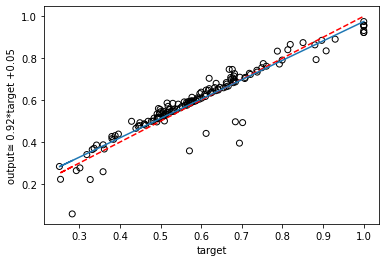

In [6]:
xx=df2['target']
yy=df2['predict']

# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    #print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

# solution
a1, b1 = best_fit(xx, yy)
#best fit line:
#y = 0.80 + 0.92x

# plot points and fit line

plt.scatter(xx, yy,marker='o',edgecolors='black',facecolors='none')
plt.plot(xx,xx,ls='--',color='r')
y1fit = [a1 + b1 * xi for xi in xx]
plt.plot(xx, y1fit)
plt.xlabel('target')
plt.ylabel('output≅ {}*target +{}'.format(round(b1,2),round(a1,2)))
#plt.savefig('fariba.jpg')

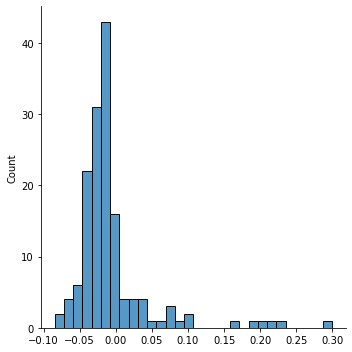

In [7]:
sns.displot(df2['target']-df2['predict'],bins=30)

# predict BPNN

Text(0, 0.5, 'output≅ 0.87*target +0.08')

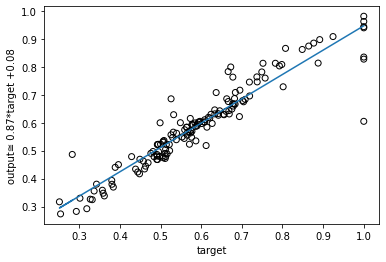

In [9]:
# sample points 
#X = [result['target'][1],result['target'][2], result['target'][3],result['target'][4],result['target'][5],
    # result['target'][6], result['target'][7],result['target'][8]]
#Y = [ result['output'][1], result['output'][2], result['output'][3], result['output'][4],
     #result['output'][5], result['output'][6], result['output'][7], result['output'][8]]
    
X=result['target']
Y=result['output']

# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    #print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

# solution
a, b = best_fit(X, Y)
#best fit line:
#y = 0.80 + 0.92x

# plot points and fit line

plt.scatter(X, Y,marker='o',edgecolors='black',facecolors='none')
yfit = [a + b * xi for xi in X]
plt.plot(X, yfit)
plt.xlabel('target')
plt.ylabel('output≅ {}*target +{}'.format(round(b,2),round(a,2)))

#plt.savefig('fariba.jpg')

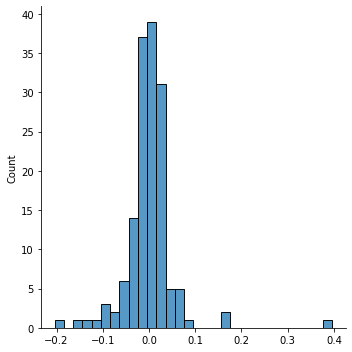

In [10]:
sns.displot(result['target']-result['output'],bins=30)

# relative_error

In [21]:
Relative_error=pd.DataFrame(index=np.arange(1,number_of_data+1), columns=['DMU','BPNN','type'])

for i in range(len(x_train_ccr[:,0])):
    k=int(x_train_ccr[i,0])
    e=BPNN['Relative-Error'][i]
    Relative_error.loc[k]=[k,e,'train']
for i in range(len(x_test_ccr[:,0])):
    k=int(x_test_ccr[i,0])
    e=BPNN_Test['Relative-Error'][i]
    Relative_error.loc[k]=[k,e,'test']



# plot relative-error

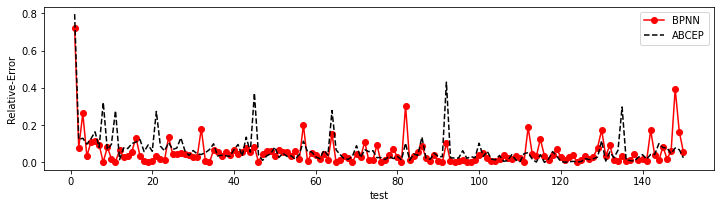

In [15]:
fig=plt.figure(figsize=(12,3))
plt.plot('DMU','BPNN',data=Relative_error,color='red',marker='o')
plt.plot('DMU','ABCEP',data=df2,color='black',linestyle='--')
#yfit = [a + b * xi for xi in X]
#plt.plot(X, yfit)
plt.xlabel('test')
plt.ylabel('Relative-Error')
plt.legend()
plt.show()


# mse


In [22]:
#-ABCEP

df1=pd.read_excel('D:\\learning article\\final\\mse.xlsx')
df1['Best']=df1['error-ccr'][len(df1)-1]   
BPNN_mse=pd.DataFrame(index=np.arange(0,iteration),columns=['Epochs','CCR-Train'])
for i in range(iteration):
    BPNN_mse.iloc[i]=[i+1,BPNN['MSE'][i]]

BPNN_mse['Best']=BPNN_mse['CCR-Train'][len(BPNN_mse)-1]  

#ylim=(min(min(df1['CCR-Train']),min(BPNN_mse['CCR-Train']))-0.01,
#max(max(df1['CCR-Train']),max(BPNN_mse['CCR-Train']))+0.01)
#ylim= [0.000001,0.00001,0.0001,0.01,1.0]
#ylim=(0.000001,0.01)

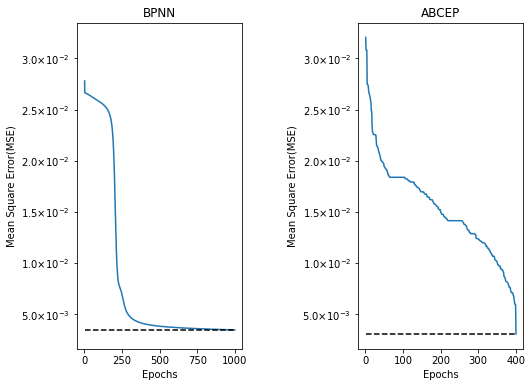

In [27]:


fig, axes = plt.subplots(1, 2,  figsize=(8, 6),sharey=True)

axes[0].plot('Epochs','CCR-Train',data=BPNN_mse)
axes[0].plot('Epochs','Best',data=BPNN_mse,color='black',linestyle='--')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Mean Square Error(MSE)')
axes[0].set_title('BPNN')
#axes[0].set_ylim(ylim)

#axes[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%1.1e'))

axes[1].plot('Epochs','CCR-Train',data=df1)
axes[1].plot('Epochs','Best',data=df1,color='black',linestyle='--')

axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Mean Square Error(MSE)')
axes[1].set_title('ABCEP')

#fig.tight_layout(h_pad=1.5,w_pad=0.5)
fig.subplots_adjust(wspace=0.7, hspace=0.6)
#axes[1].set_ylim(ylim)
#axes[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%1.1e'))
#plt.show()


class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)

# Format with 2 decimal places
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.1e"))
plt.tick_params(labelleft=True )


In [ ]:
#BCC
